In [1]:
# -*- coding: utf-8 -*-
"""Fine-tuning BERT for NER (Named Entity Recognition)"""

# Install necessary libraries for Colab
!pip install transformers torch

# Import libraries
import csv
import os
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report

In [2]:
# Download the MIT Movie Corpus files
!wget -q https://sls.csail.mit.edu/downloads/movie/engtrain.bio -O engtrain.bio
!wget -q https://sls.csail.mit.edu/downloads/movie/engtest.bio -O engtest.bio

print("Downloaded dataset files.")

Downloaded dataset files.


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Helper function to load and process data
def get_sentences_and_labels(file_path):
    sentences = []  # Store tokenized words lists for each sentence
    labels = []     # Store labels for each word in a sentence
    unique_labels = set()  # Track unique labels

    # Temporary storage for the current sentence
    tokens = []
    token_labels = []

    with open(file_path, newline='', encoding='utf-8') as file:
        line_reader = csv.reader(file, delimiter='\t')

        for line in line_reader:
            # Ignore empty or improperly formatted lines
            if not line or len(line) < 2:
                if tokens:  # End of a sentence
                    sentences.append(tokens)
                    labels.append(token_labels)
                    tokens = []
                    token_labels = []
                continue

            # Extract token and label
            token, label = line[1], line[0]
            tokens.append(token)
            token_labels.append(label)
            unique_labels.add(label)

    # Append the last sentence if not empty
    if tokens:
        sentences.append(tokens)
        labels.append(token_labels)

    return sentences, labels, unique_labels

# Paths to the downloaded dataset files
train_file_path = 'engtrain.bio'
test_file_path = 'engtest.bio'

# Extract sentences, labels, and unique labels for train and test datasets
train_sentences, train_labels, unique_labels_train = get_sentences_and_labels(train_file_path)
test_sentences, test_labels, unique_labels_test = get_sentences_and_labels(test_file_path)

# Combine unique labels from train and test
unique_labels = unique_labels_train.union(unique_labels_test)

# Print dataset details
print(f"Number of sentences in training data: {len(train_sentences)}")
print(f"Number of sentences in testing data: {len(test_sentences)}")
print(f"Number of unique labels: {len(unique_labels)}")

# Create a label-to-ID mapping
label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}
print(f"Label Map: {label_map}")

Number of sentences in training data: 9775
Number of sentences in testing data: 2443
Number of unique labels: 25
Label Map: {'B-ACTOR': 0, 'B-CHARACTER': 1, 'B-DIRECTOR': 2, 'B-GENRE': 3, 'B-PLOT': 4, 'B-RATING': 5, 'B-RATINGS_AVERAGE': 6, 'B-REVIEW': 7, 'B-SONG': 8, 'B-TITLE': 9, 'B-TRAILER': 10, 'B-YEAR': 11, 'I-ACTOR': 12, 'I-CHARACTER': 13, 'I-DIRECTOR': 14, 'I-GENRE': 15, 'I-PLOT': 16, 'I-RATING': 17, 'I-RATINGS_AVERAGE': 18, 'I-REVIEW': 19, 'I-SONG': 20, 'I-TITLE': 21, 'I-TRAILER': 22, 'I-YEAR': 23, 'O': 24}


In [5]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Prepare input IDs and attention masks
def get_input_ids_and_attention_masks(sentences):
    input_ids = []
    attention_masks = []
    for sentence in sentences:
        joined_sentence = ' '.join(sentence)
        encoded = tokenizer.encode_plus(
            joined_sentence,
            add_special_tokens=True,
            max_length=59,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
    return input_ids, attention_masks

# Tokenize and encode
train_input_ids, train_attention_masks = get_input_ids_and_attention_masks(train_sentences)
test_input_ids, test_attention_masks = get_input_ids_and_attention_masks(test_sentences)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:

# Pad labels
def pad_labels(input_ids, labels, label_map):
    padded_labels = []
    for sent, orig_labels in zip(input_ids, labels):
        curr_labels = []
        label_idx = 0
        for token_id in sent:
            token_id = token_id.item()
            if token_id in {tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id}:
                curr_labels.append(-100)
            elif tokenizer.decode([token_id]).startswith("##"):
                curr_labels.append(-100)
            else:
                curr_labels.append(label_map[orig_labels[label_idx]])
                label_idx += 1
        assert len(sent) == len(curr_labels)
        padded_labels.append(curr_labels)
    return padded_labels

# Prepare labels
train_padded_labels = pad_labels(train_input_ids, train_labels, label_map)
test_padded_labels = pad_labels(test_input_ids, test_labels, label_map)

In [7]:
# Convert to tensors
train_input_ids_tensor = torch.stack(train_input_ids)
train_attention_masks_tensor = torch.stack(train_attention_masks)
train_padded_labels_tensor = torch.tensor(train_padded_labels)

test_input_ids_tensor = torch.stack(test_input_ids)
test_attention_masks_tensor = torch.stack(test_attention_masks)
test_padded_labels_tensor = torch.tensor(test_padded_labels)

# Split test set into validation and final test
val_size = int(0.2 * len(test_input_ids_tensor))
test_size = len(test_input_ids_tensor) - val_size

val_indices, final_test_indices = random_split(range(len(test_input_ids_tensor)), [val_size, test_size])

val_input_ids = test_input_ids_tensor[val_indices.indices]
val_attention_masks = test_attention_masks_tensor[val_indices.indices]
val_labels = test_padded_labels_tensor[val_indices.indices]

final_test_input_ids = test_input_ids_tensor[final_test_indices.indices]
final_test_attention_masks = test_attention_masks_tensor[final_test_indices.indices]
final_test_labels = test_padded_labels_tensor[final_test_indices.indices]

In [8]:
batch_size = 32

# Define training dataset and DataLoader
train_dataset = TensorDataset(train_input_ids_tensor, train_attention_masks_tensor, train_padded_labels_tensor)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# Validation DataLoader from the validation subset (20% of test data)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Final test dataset and DataLoader
final_test_dataset = TensorDataset(final_test_input_ids, final_test_attention_masks, final_test_labels)
final_test_dataloader = DataLoader(final_test_dataset, sampler=SequentialSampler(final_test_dataset), batch_size=batch_size)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Training...
  Training loss: 0.42
Evaluating on test set...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Test Results for Epoch 1:
                   precision    recall  f1-score   support

          B-ACTOR       0.92      0.91      0.92       652
      B-CHARACTER       0.61      0.55      0.58        66
       B-DIRECTOR       0.90      0.86      0.88       365
          B-GENRE       0.90      0.97      0.94       906
           B-PLOT       0.76      0.72      0.74       402
         B-RATING       0.98      0.97      0.97       402
B-RATINGS_AVERAGE       0.86      0.93      0.89       372
         B-REVIEW       0.47      0.16      0.23        45
           B-SONG       0.85      0.63      0.72        46
          B-TITLE       0.84      0.90      0.87       438
        B-TRAILER       0.76      0.83      0.79        23
           B-YEAR       0.95      0.95      0.95       575
          I-ACTOR       0.91      0.92      0.92       689
      I-CHARACTER       0.53      0.45      0.49        64
       I-DIRECTOR       0.91      0.86      0.89       392
          I-GENRE       0.92 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Test Results for Epoch 2:
                   precision    recall  f1-score   support

          B-ACTOR       0.94      0.89      0.91       652
      B-CHARACTER       0.62      0.59      0.60        66
       B-DIRECTOR       0.84      0.90      0.87       365
          B-GENRE       0.93      0.97      0.95       906
           B-PLOT       0.74      0.80      0.77       402
         B-RATING       0.95      0.97      0.96       402
B-RATINGS_AVERAGE       0.93      0.91      0.92       372
         B-REVIEW       0.43      0.13      0.20        45
           B-SONG       0.66      0.76      0.71        46
          B-TITLE       0.88      0.90      0.89       438
        B-TRAILER       0.77      0.87      0.82        23
           B-YEAR       0.94      0.96      0.95       575
          I-ACTOR       0.93      0.90      0.92       689
      I-CHARACTER       0.60      0.44      0.50        64
       I-DIRECTOR       0.85      0.90      0.87       392
          I-GENRE       0.91 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Test Results for Epoch 3:
                   precision    recall  f1-score   support

          B-ACTOR       0.92      0.94      0.93       652
      B-CHARACTER       0.62      0.61      0.62        66
       B-DIRECTOR       0.92      0.88      0.90       365
          B-GENRE       0.94      0.97      0.96       906
           B-PLOT       0.78      0.77      0.77       402
         B-RATING       0.94      0.97      0.96       402
B-RATINGS_AVERAGE       0.91      0.94      0.92       372
         B-REVIEW       0.41      0.24      0.31        45
           B-SONG       0.76      0.74      0.75        46
          B-TITLE       0.88      0.89      0.89       438
        B-TRAILER       0.77      0.87      0.82        23
           B-YEAR       0.94      0.96      0.95       575
          I-ACTOR       0.91      0.95      0.93       689
      I-CHARACTER       0.57      0.47      0.51        64
       I-DIRECTOR       0.93      0.87      0.90       392
          I-GENRE       0.87 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Test Results for Epoch 4:
                   precision    recall  f1-score   support

          B-ACTOR       0.93      0.94      0.93       652
      B-CHARACTER       0.58      0.62      0.60        66
       B-DIRECTOR       0.91      0.89      0.90       365
          B-GENRE       0.94      0.97      0.95       906
           B-PLOT       0.79      0.76      0.77       402
         B-RATING       0.96      0.97      0.97       402
B-RATINGS_AVERAGE       0.94      0.92      0.93       372
         B-REVIEW       0.41      0.29      0.34        45
           B-SONG       0.76      0.76      0.76        46
          B-TITLE       0.88      0.89      0.89       438
        B-TRAILER       0.77      0.87      0.82        23
           B-YEAR       0.95      0.96      0.95       575
          I-ACTOR       0.92      0.94      0.93       689
      I-CHARACTER       0.55      0.42      0.48        64
       I-DIRECTOR       0.92      0.88      0.90       392
          I-GENRE       0.84 

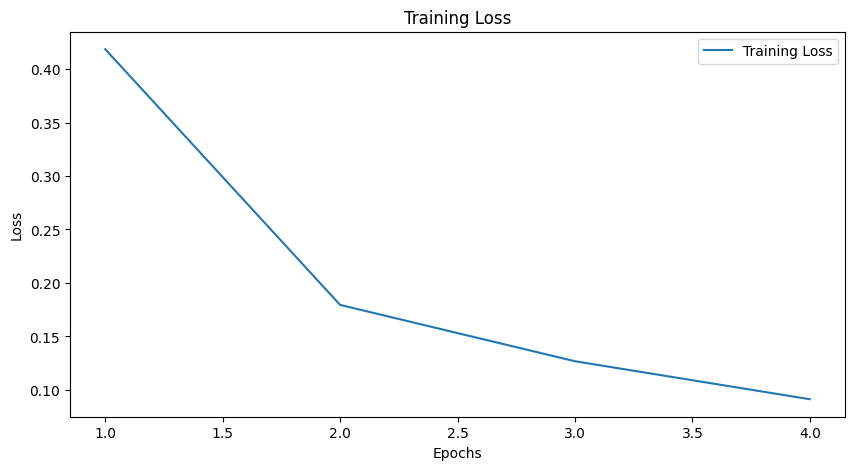

Test results saved to test_results_per_epoch.csv


In [9]:
# Initialize the BERT model for token classification
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_map) + 1  # Account for the padding label (-100)
)
model.to(device)

epochs = 4

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)  # Standard learning rate and epsilon values
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss_values = []
test_results_per_epoch = []  # To store test evaluation results per epoch

for epoch in range(epochs):
    print(f"======== Epoch {epoch + 1} / {epochs} ========")

    # Training phase
    print("Training...")
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [item.to(device) for item in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)
    print(f"  Training loss: {avg_train_loss:.2f}")

    # Test evaluation after each epoch
    print("Evaluating on test set...")
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in final_test_dataloader:
            b_input_ids, b_input_mask, b_labels = [item.to(device) for item in batch]
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2).cpu().numpy()
            labels = b_labels.cpu().numpy()
            for pred, label in zip(preds, labels):
                predictions.append(pred[label != -100])
                true_labels.append(label[label != -100])
    # Flatten predictions and true labels
    flat_preds = [item for sublist in predictions for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    # Remove padding labels (-100) from `label_map`
    label_names = [key for key, value in sorted(label_map.items(), key=lambda x: x[1]) if key != -100]

    # Generate classification report for test set
    report = classification_report(
        flat_true,
        flat_preds,
        target_names=label_names[:len(set(flat_true))],  # Ensure matching size
        output_dict=True
    )

    # Display report
    print(f"Test Results for Epoch {epoch + 1}:")
    print(classification_report(flat_true, flat_preds, target_names=label_names[:len(set(flat_true))]))

    # Store results for later analysis
    test_results_per_epoch.append(report)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_values, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()

# Optional: Save the test results for all epochs
import pandas as pd
results_df = pd.DataFrame(test_results_per_epoch)
results_df.to_csv("test_results_per_epoch.csv", index=False)
print("Test results saved to test_results_per_epoch.csv")

In [10]:
# Testing the model
test_sentence = "Can you tell me the publication date of Tom Meets Zizou?"
encoded_test = tokenizer.encode_plus(
    test_sentence,
    add_special_tokens=True,
    max_length=59,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_test['input_ids'].to(device)
attention_mask = encoded_test['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=2).cpu().numpy()

# Decode predictions
for token, label_id in zip(tokenizer.convert_ids_to_tokens(input_ids[0]), predictions[0]):
    if label_id != -100:
        print(f"{token}: {list(label_map.keys())[list(label_map.values()).index(label_id)]}")

[CLS]: O
Can: O
you: O
tell: O
me: O
the: O
publication: O
date: O
of: O
Tom: B-TITLE
Meet: I-TITLE
##s: I-TITLE
Z: I-TITLE
##iz: I-TITLE
##ou: I-TITLE
?: I-TITLE
[SEP]: O
[PAD]: O
[PAD]: I-TITLE
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: B-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: B-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: I-TITLE
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: B-TITLE
[PAD]: I-TITLE


In [11]:
# # Define a function to evaluate the model on the final test set
# def evaluate_model(model, dataloader, label_map):
#     model.eval()
#     predictions, true_labels = [], []

#     with torch.no_grad():
#         for batch in dataloader:
#             b_input_ids, b_input_mask, b_labels = [item.to(device) for item in batch]
#             outputs = model(b_input_ids, attention_mask=b_input_mask)
#             logits = outputs.logits
#             preds = torch.argmax(logits, dim=2).cpu().numpy()
#             labels = b_labels.cpu().numpy()

#             for pred, label in zip(preds, labels):
#                 predictions.append(pred[label != -100])  # Filter out padding labels
#                 true_labels.append(label[label != -100])

#     flat_preds = [label for sublist in predictions for label in sublist]
#     flat_labels = [label for sublist in true_labels for label in sublist]
#     return classification_report(flat_labels, flat_preds)

# # Evaluate the model
# print(evaluate_model(model, final_test_dataloader, label_map))

In [12]:
# import os

# # Define a directory to save the model
# output_dir = "./fine_tuned_bert_model"

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Save the model
# model.save_pretrained(output_dir)

# # Save the tokenizer
# tokenizer.save_pretrained(output_dir)

# print(f"Model and tokenizer saved to {output_dir}")


In [15]:
files.download('fine_tuned_bert_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
import shutil

# Define the path in Google Drive where you want to save the zip file
drive_path = '/content/drive/My Drive/fine_tuned_bert_model'

# Zip the model directory and save it to Google Drive
shutil.make_archive(drive_path, 'zip', './fine_tuned_bert_model')

print(f"Model saved to {drive_path}.zip")


Model saved to /content/drive/My Drive/fine_tuned_bert_model.zip
